In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import networkx as nx
import osmnx as ox
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
ox.config(log_console=True)

#Import the gtfs-kit module
import gtfs_kit as gk

#Declare the directory path for the GTFS zip file
path = 'C:\\Users\\Joonas\\Downloads\\gtfs.zip'
#Read the feed with gtfs-kit
feed = (gk.read_feed(path, dist_units='km'))

#Search for errors and warnings in the feed
feed.validate()

,type,message,table,rows
3,error,Invalid route_type; maybe has extra space char...,routes,"[9, 872, 1119, 1352]"
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,Unrecognized column feed_id,feed_info,[]
2,warning,Unrecognized column competent_authority,routes,[]
11,warning,"Repeated pair (trip_id, departure_time)",stop_times,"[258356, 258358, 259076, 259078, 259112, 25911..."
4,warning,Unrecognized column alias,stops,[]
5,warning,Unrecognized column stop_area,stops,[]
6,warning,Unrecognized column lest_x,stops,[]
7,warning,Unrecognized column lest_y,stops,[]
8,warning,Unrecognized column zone_name,stops,[]


In [27]:
stops = pd.DataFrame(feed.stops)

In [36]:
stop_times = pd.DataFrame(feed.stop_times)

### Filter by Tartu

In [172]:
tartu_stops = stops[stops.stop_area == "Tartu linn"]
tartu_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,alias,stop_area,stop_desc,lest_x,lest_y,zone_name,authority
59,149241,7820372-1,Ropka tee,58.355906,26.740854,149241,NaN,Tartu linn,Kesklinn suunas,6471652.50,660410.18,NaN,Tartu LV
327,123046,7820208-1,Raudteejaam,58.373975,26.706821,123046,NaN,Tartu linn,Tähtvere suunas,6473582.44,658338.28,TartuLinn,Tartu LV
343,26673,7820163-1,Nooruse,58.366432,26.695272,26673,NaN,Tartu linn,NaN,6472715.83,657696.77,TartuLinn,Tartu LV
548,24876,7820088-1,Kesklinn II,58.377240,26.727902,24876,NaN,Tartu linn,Kvartali ees,6473995.82,659555.94,TartuLinn,Tartu LV
597,26227,7820140-1,Maarjamõisa,58.369602,26.701729,26227,NaN,Tartu linn,Kesklinna suunas,6473083.78,658060.14,TartuLinn,Tartu LV
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17151,24717,7820033-1,E-Kaubamaja,58.358493,26.730782,24717,NaN,Tartu linn,Ropkamõisa suunas,6471916.42,659809.30,TartuLinn,Tartu LV
17152,33511,7820273-1,Tartu Maja IV,58.381832,26.685393,33511,NaN,Tartu linn,raudtee suunas,6474406.50,657050.43,TartuLinn,Tartu LV
17167,138205,7820340-1,Hotell Sophia,58.356778,26.678717,138205,NaN,Tartu linn,NaN,6471602.70,656771.61,NaN,Tartu LV
17205,133806,7820328-1,Jaama,58.384073,26.740271,133806,NaN,Tartu linn,kesklinna suunas,6474785.76,660247.94,NaN,Tartu LV


In [173]:
tartu_stop_ids = np.unique(tartu_stops.stop_id.values)

In [174]:
tartu_stop_times = stop_times[stop_times["stop_id"].isin(tartu_stop_ids)].copy()
tartu_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
1457,1084422,18:25:00,18:25:00,128367,18,1,0
1458,1084422,18:26:00,18:26:00,33516,19,1,0
1459,1084422,18:28:00,18:28:00,26092,20,1,0
1460,1084422,18:32:00,18:32:00,26398,21,1,0
1461,1084422,18:35:00,18:35:00,33385,22,0,0
...,...,...,...,...,...,...,...
810863,1155417,17:29:00,17:29:00,34123,8,0,0
810897,1155420,16:10:00,16:10:00,34210,7,0,0
810898,1155421,16:30:00,16:30:00,34112,1,0,0
810911,1155422,16:10:00,16:10:00,34210,7,0,0


### Normalize datetimes

In [175]:
def my_to_datetime(date_str):
    try:
        if date_str[:2] != '24':
            return pd.to_datetime(date_str, format= '%H:%M:%S').strftime('%H:%M:%S')

        date_str = '00' + date_str[2:]
        return pd.to_datetime(date_str, format= '%H:%M:%S').strftime('%H:%M:%S')
    except:
        return np.NaN

print(my_to_datetime('14:30:00'))

14:30:00


In [176]:
trips = np.unique(tartu_stop_times.trip_id.values)

In [178]:
tartu_stop_times['arrival_time'] = tartu_stop_times['arrival_time'].apply(my_to_datetime)

In [179]:
tartu_stop_times['departure_time'] = tartu_stop_times['departure_time'].apply(my_to_datetime)

In [180]:
tartu_stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
1457,1084422,18:25:00,18:25:00,128367,18,1,0
1458,1084422,18:26:00,18:26:00,33516,19,1,0
1459,1084422,18:28:00,18:28:00,26092,20,1,0
1460,1084422,18:32:00,18:32:00,26398,21,1,0
1461,1084422,18:35:00,18:35:00,33385,22,0,0


In [181]:
tartu_stop_times = tartu_stop_times[["trip_id","arrival_time","departure_time","stop_id","stop_sequence"]]

In [182]:
tartu_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence
1457,1084422,18:25:00,18:25:00,128367,18
1458,1084422,18:26:00,18:26:00,33516,19
1459,1084422,18:28:00,18:28:00,26092,20
1460,1084422,18:32:00,18:32:00,26398,21
1461,1084422,18:35:00,18:35:00,33385,22
...,...,...,...,...,...
810863,1155417,17:29:00,17:29:00,34123,8
810897,1155420,16:10:00,16:10:00,34210,7
810898,1155421,16:30:00,16:30:00,34112,1
810911,1155422,16:10:00,16:10:00,34210,7


In [183]:
tartu_stop_times = tartu_stop_times.dropna()

In [169]:
tartu_stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence
1457,1084422,18:25:00,18:25:00,128367,18
1458,1084422,18:26:00,18:26:00,33516,19
1459,1084422,18:28:00,18:28:00,26092,20
1460,1084422,18:32:00,18:32:00,26398,21
1461,1084422,18:35:00,18:35:00,33385,22
...,...,...,...,...,...
810863,1155417,17:29:00,17:29:00,34123,8
810897,1155420,16:10:00,16:10:00,34210,7
810898,1155421,16:30:00,16:30:00,34112,1
810911,1155422,16:10:00,16:10:00,34210,7


### Calculate edges 

In [188]:
edges = pd.DataFrame()


for trip_id in trips:
    
    single_trip = tartu_stop_times[tartu_stop_times.trip_id == trip_id].copy()
    
    single_trip = single_trip.sort_values(by = "stop_sequence")
    
    single_trip["target_stop"] =single_trip["stop_id"].shift(-1)
    single_trip["target_time"] =single_trip["arrival_time"].shift(-1)
    
    single_trip = single_trip.iloc[:-1 , :]
    
    single_trip["time"] = pd.to_datetime(single_trip["target_time"]) - pd.to_datetime(single_trip["departure_time"])
    
    edges = edges.append(single_trip)


In [233]:
edges

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,target_stop,target_time,time
282212,1006963,06:07:00,06:07:00,122419,2,24721,06:08:00,0 days 00:01:00
282213,1006963,06:08:00,06:08:00,24721,3,26104,06:09:00,0 days 00:01:00
282214,1006963,06:09:00,06:09:00,26104,4,26386,06:11:00,0 days 00:02:00
282215,1006963,06:11:00,06:11:00,26386,5,25951,06:12:00,0 days 00:01:00
282216,1006963,06:12:00,06:12:00,25951,6,25024,06:13:00,0 days 00:01:00
...,...,...,...,...,...,...,...,...
258273,996417,20:13:00,20:13:00,26256,15,128376,20:14:00,0 days 00:01:00
258274,996417,20:14:00,20:14:00,128376,16,128374,20:15:00,0 days 00:01:00
258275,996417,20:15:00,20:15:00,128374,17,128372,20:16:00,0 days 00:01:00
258276,996417,20:16:00,20:16:00,128372,18,128368,20:17:00,0 days 00:01:00


In [234]:
graph_edges = edges[["stop_id","target_stop","time"]].copy()

In [236]:
graph_edges["time"] = graph_edges["time"].astype('timedelta64[m]')

In [240]:
final_edges = graph_edges.groupby(["stop_id", "target_stop"]).mean().round(2).reset_index()

In [241]:
final_edges

,stop_id,target_stop,time
0,116720,116721,1.00
1,116721,122429,1.69
2,119583,24717,1.67
3,119592,33512,2.00
4,122419,122419,0.00
...,...,...,...
608,34153,34112,4.00
609,34210,34123,4.00
610,34210,34209,4.00
611,91878,20040,1.00


In [242]:
tartu_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,alias,stop_area,stop_desc,lest_x,lest_y,zone_name,authority
59,149241,7820372-1,Ropka tee,58.355906,26.740854,149241,NaN,Tartu linn,Kesklinn suunas,6471652.50,660410.18,NaN,Tartu LV
327,123046,7820208-1,Raudteejaam,58.373975,26.706821,123046,NaN,Tartu linn,Tähtvere suunas,6473582.44,658338.28,TartuLinn,Tartu LV
343,26673,7820163-1,Nooruse,58.366432,26.695272,26673,NaN,Tartu linn,NaN,6472715.83,657696.77,TartuLinn,Tartu LV
548,24876,7820088-1,Kesklinn II,58.377240,26.727902,24876,NaN,Tartu linn,Kvartali ees,6473995.82,659555.94,TartuLinn,Tartu LV
597,26227,7820140-1,Maarjamõisa,58.369602,26.701729,26227,NaN,Tartu linn,Kesklinna suunas,6473083.78,658060.14,TartuLinn,Tartu LV
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17151,24717,7820033-1,E-Kaubamaja,58.358493,26.730782,24717,NaN,Tartu linn,Ropkamõisa suunas,6471916.42,659809.30,TartuLinn,Tartu LV
17152,33511,7820273-1,Tartu Maja IV,58.381832,26.685393,33511,NaN,Tartu linn,raudtee suunas,6474406.50,657050.43,TartuLinn,Tartu LV
17167,138205,7820340-1,Hotell Sophia,58.356778,26.678717,138205,NaN,Tartu linn,NaN,6471602.70,656771.61,NaN,Tartu LV
17205,133806,7820328-1,Jaama,58.384073,26.740271,133806,NaN,Tartu linn,kesklinna suunas,6474785.76,660247.94,NaN,Tartu LV


In [243]:
nodes = tartu_stops[["stop_id","stop_name","stop_lat","stop_lon"]]

In [244]:
nodes

,stop_id,stop_name,stop_lat,stop_lon
59,149241,Ropka tee,58.355906,26.740854
327,123046,Raudteejaam,58.373975,26.706821
343,26673,Nooruse,58.366432,26.695272
548,24876,Kesklinn II,58.377240,26.727902
597,26227,Maarjamõisa,58.369602,26.701729
...,...,...,...,...
17151,24717,E-Kaubamaja,58.358493,26.730782
17152,33511,Tartu Maja IV,58.381832,26.685393
17167,138205,Hotell Sophia,58.356778,26.678717
17205,133806,Jaama,58.384073,26.740271


### Save the nodes and edges

In [245]:
nodes.to_csv("nodes.csv")
final_edges.to_csv("edges.csv")

### Load nodes and edges

In [2]:
nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")

In [247]:
#G = nx.from_pandas_edgelist(final_edges, source='stop_id', target='target_stop',edge_attr=True)

### Graph creation

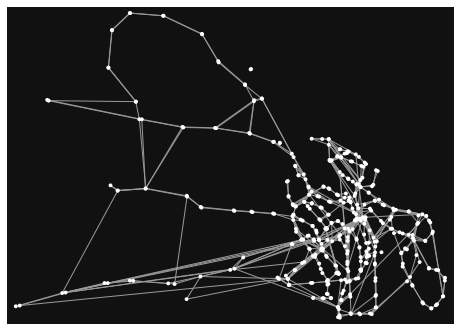

In [3]:
G_bus = nx.MultiDiGraph()
G_bus.add_nodes_from(nodes["stop_id"])
nodes = nodes.rename(columns={"stop_lat": "y", "stop_lon": "x"})

df_attributes_only = nodes[["stop_id","x","y"]]
node_attr = df_attributes_only.set_index('stop_id').to_dict('index')
nx.set_node_attributes(G_bus, node_attr)

G_bus.graph["crs"] = 'epsg:4326'

G_bus.add_edges_from(list(zip(edges["stop_id"],edges["target_stop"])))

fig, ax = ox.plot_graph(G_bus)

### Some legacy formating

In [7]:
new_edges = pd.DataFrame(list(G_bus.edges), columns = ["stop_id", "target_stop","x"])
newest_edges = new_edges.merge(edges, left_on = ["stop_id", "target_stop"], right_on = ["stop_id", "target_stop"])
edge_attributes_only = newest_edges[["stop_id","target_stop","time","x"]]
edge_attr = edge_attributes_only.set_index(["stop_id","target_stop","x"]).to_dict('index')
nx.set_edge_attributes(G_bus,edge_attr)

### Bounding box of Tartu

In [8]:
#bounding box for Tartu
bbox = (58.42,58.33,26.81,26.64)

In [9]:
bus_nodes = list(G_bus.nodes) 

In [10]:
degrees = [G_bus.degree(n) for n in G_bus.nodes()]

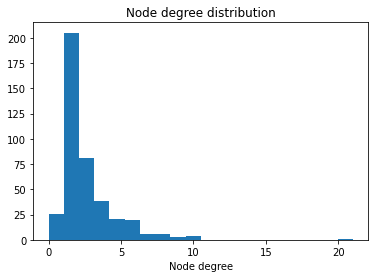

In [11]:
plt.hist(degrees, bins = 20)
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.show()

In [12]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G_bus, weight = "time"), weight="time")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(33385, 0.35488997555012225)

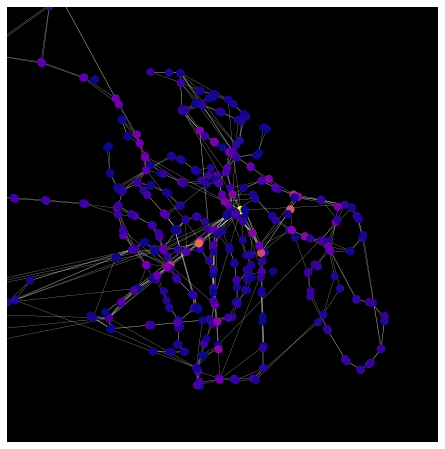

In [13]:
nx.set_node_attributes(G_bus, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G_bus, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G_bus,
    node_color=nc,
    node_size=70,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",bbox = bbox
)

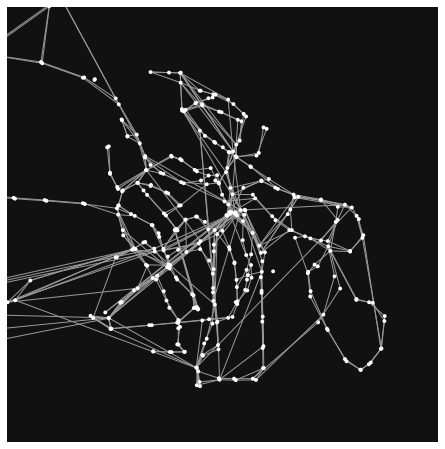

In [14]:
fig, ax = ox.plot_graph(G_bus,bbox=bbox)

In [16]:
G_city = ox.graph_from_place("Tartu, Estonia", network_type="drive")


In [17]:
G = nx.compose(G_bus, G_city)

In [18]:
nc = ["r" if node in bus_nodes else "w" for node in G.nodes]
ns = [50 if node in bus_nodes else 15 for node in G.nodes]
#fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor="k")

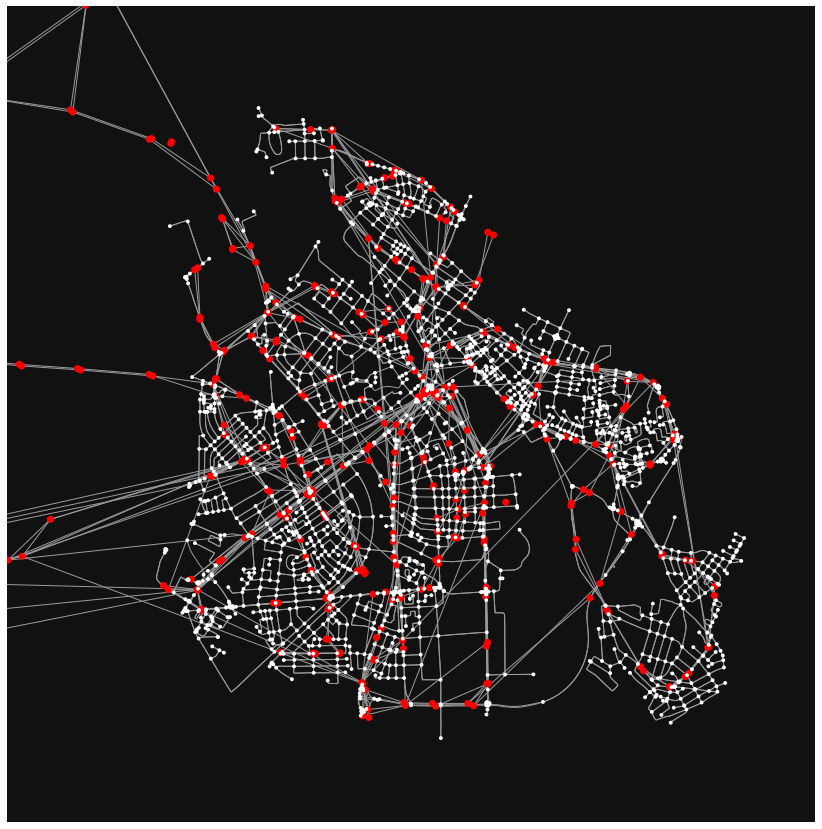

In [19]:
fig2, ax2 = ox.plot_graph(G,bbox = bbox, figsize = (15,15), node_color = nc, node_size = ns)